# conceptual leap from descriptive stats to forecasting 📈

## What is an ARIMA Model?

ARIMA stands for AutoRegressive Integrated Moving Average

It’s a statistical time series model that captures three main patterns often found in financial or temporal data:

- Autoregression (AR) → how past values influence the current one

- Integration (I) → how many times we need to difference the data to make it stationary

- Moving Average (MA) → how past errors (unexpected shocks) influence the current value

## What does ARIMA do?

It’s designed to forecast future values based on past values — for example:

- Predicting stock prices, sales next month, or temperature tomorrow.

- Anywhere you have data changing over time.

ARIMA tries to find patterns in:

    📈 Trends (steady upward or downward movement)

    🔁 Autocorrelation (past values influencing current values)

    🔊 Random noise (fluctuations)

## Why is ARIMA model our first choice in forcasting :
| Reason                              | Explanation                                                                                             |
| ----------------------------------- | ------------------------------------------------------------------------------------------------------- |
| ✅ **Works well on small data**      | You don’t need millions of samples — a few hundred time points can work.                                |
| ✅ **Handles autocorrelation**       | Financial prices and returns often depend on past patterns; ARIMA explicitly models that.               |
| ✅ **Stationarity-focused**          | It forces you to clean your data (by differencing), making trends and seasonality manageable.           |
| ✅ **Benchmark model**               | Before using LSTMs or Prophet, analysts test ARIMA — if it fails, the series is too noisy or nonlinear. |
| ✅ **Good for short-term forecasts** | Especially useful for near-term price, demand, or return predictions.                                   |

**Key Limitations**

ARIMA assumes linear relationships and no structural breaks — markets are noisy, so forecasts degrade quickly (1–5 days max).

- A rough rubric for when to use AR terms in the model is when:
    ACF plots show autocorrelation decaying towards zero
    PACF plot cuts off quickly towards zero
    ACF of a stationary series shows positive at Lag - 1

- A rough rubric for when to use MA terms in the model is when:
    Negatively Autocorrelated at Lag - 1
    ACF that drops sharply after a few lags
    PACF decreases gradually rather than suddenly

[*********************100%***********************]  1 of 1 completed


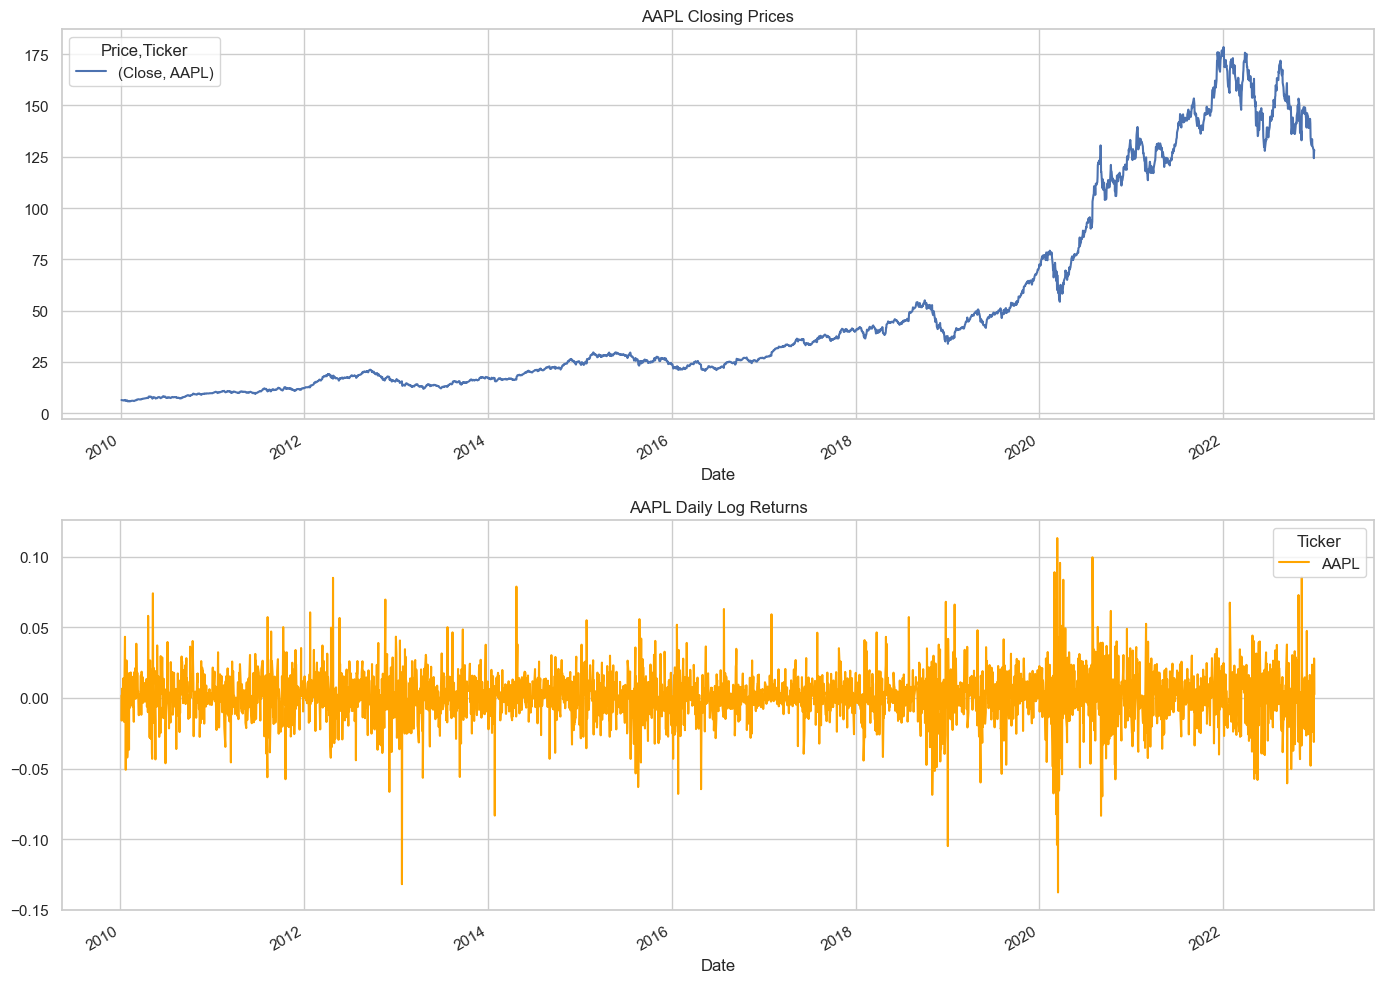

------ Stationarity Tests for Prices: ------
ADF Test for Prices: stat=-0.2178, p-value=0.9364
Null Hypothesis (H0): The series is non-stationary
--> Prices is non-stationary (fail to reject H0)
KPSS Test for Prices: stat=6.6556, p-value=0.0100
Null Hypothesis (H0): The series is stationary
--> Prices is non-stationary (reject H0)


/var/folders/kr/gft6qzsx1pd7p6nqyq9g3wd00000gn/T/ipykernel_10305/782846398.py:45: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")


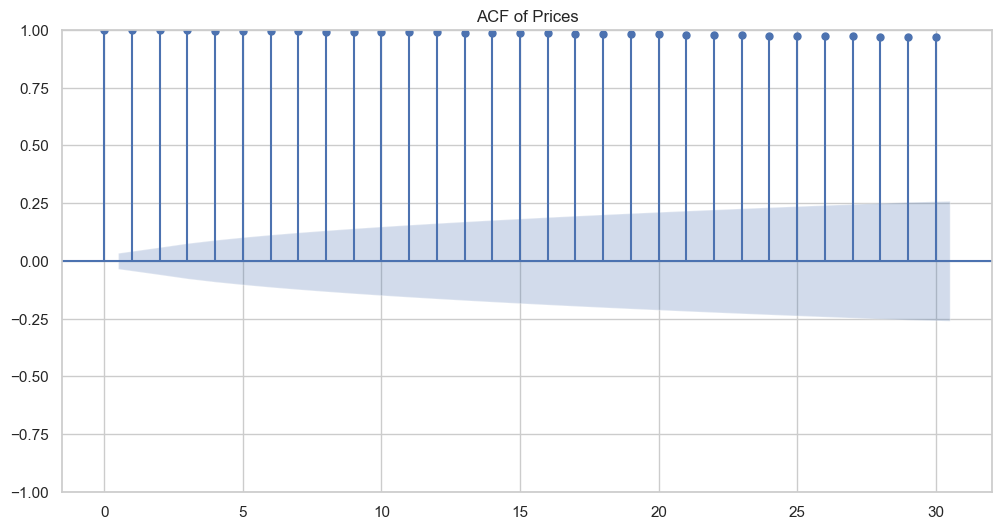

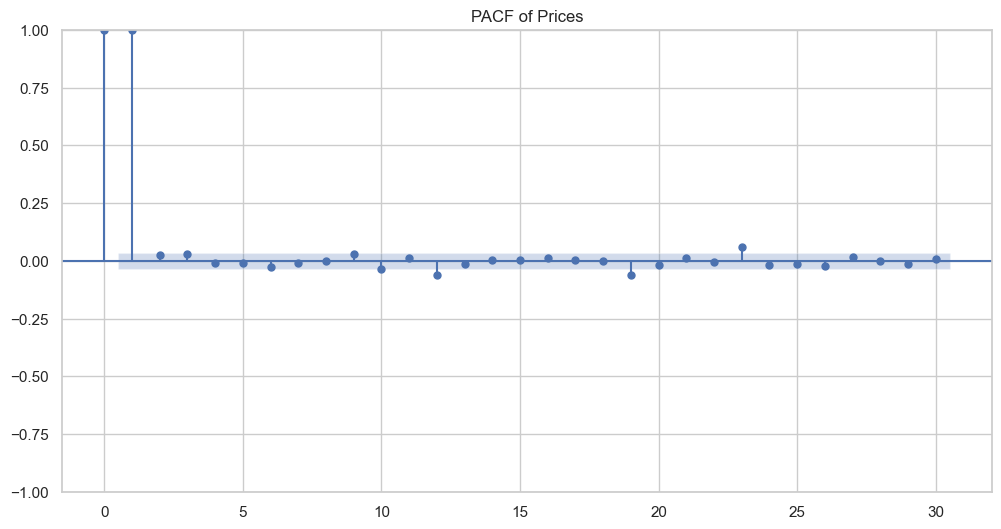


 ------- Stationarity Tests for Returns:------
ADF Test for Returns: stat=-11.6273, p-value=0.0000
Null Hypothesis (H0): The series is non-stationary
--> Returns is stationary (reject H0)
KPSS Test for Returns: stat=0.0584, p-value=0.1000
Null Hypothesis (H0): The series is stationary
--> Returns is stationary (fail to reject H0)


/var/folders/kr/gft6qzsx1pd7p6nqyq9g3wd00000gn/T/ipykernel_10305/782846398.py:45: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")


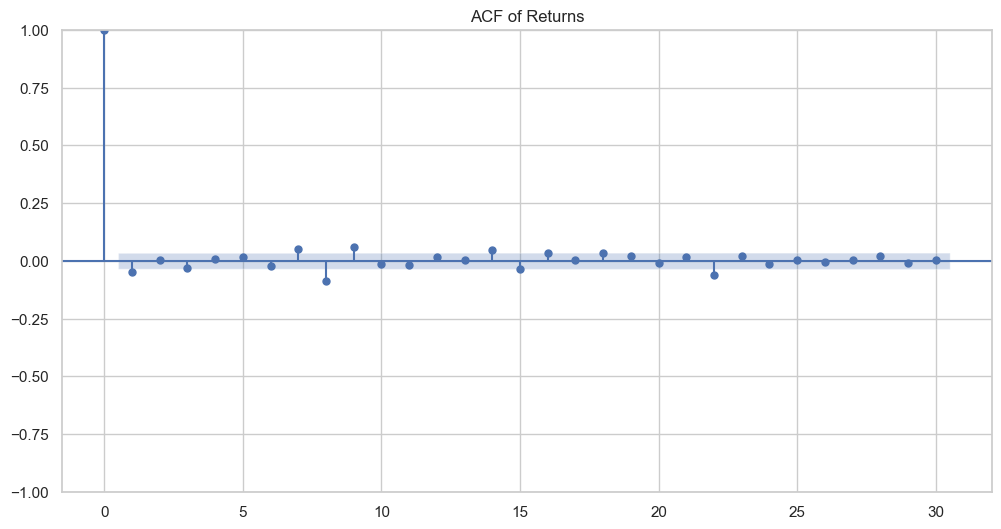

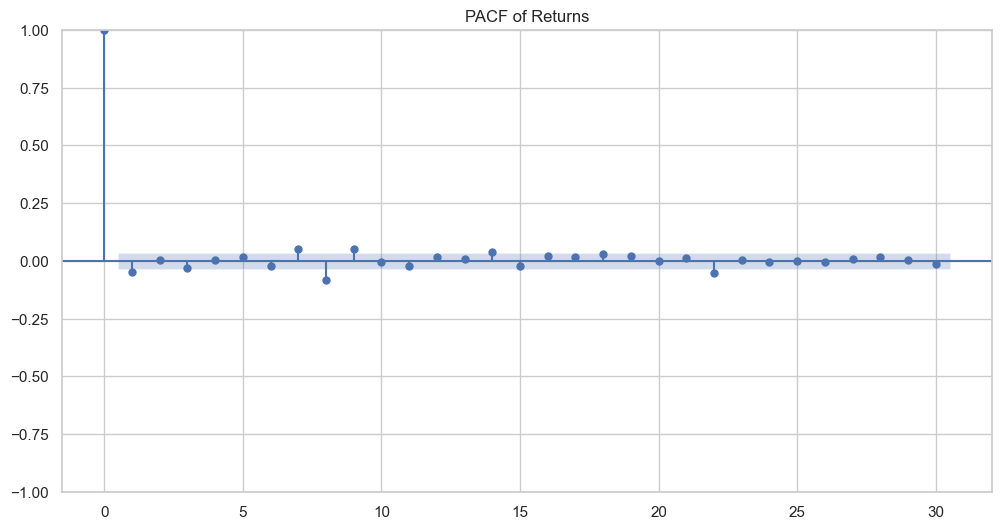

ADF Test for Price Differences: stat=-11.5916, p-value=0.0000
Null Hypothesis (H0): The series is non-stationary
--> Price Differences is stationary (reject H0)
KPSS Test for Price Differences: stat=0.1808, p-value=0.1000
Null Hypothesis (H0): The series is stationary
--> Price Differences is stationary (fail to reject H0)


/var/folders/kr/gft6qzsx1pd7p6nqyq9g3wd00000gn/T/ipykernel_10305/782846398.py:45: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")


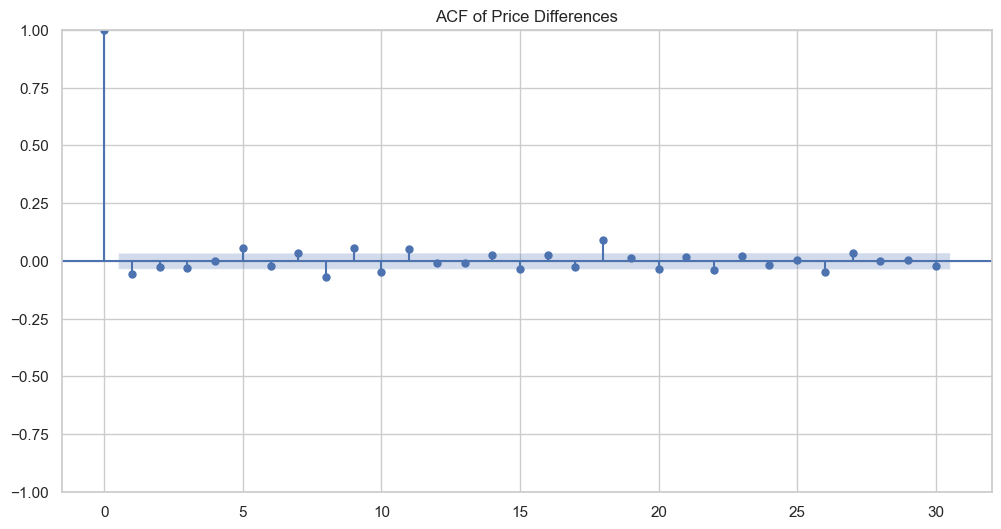

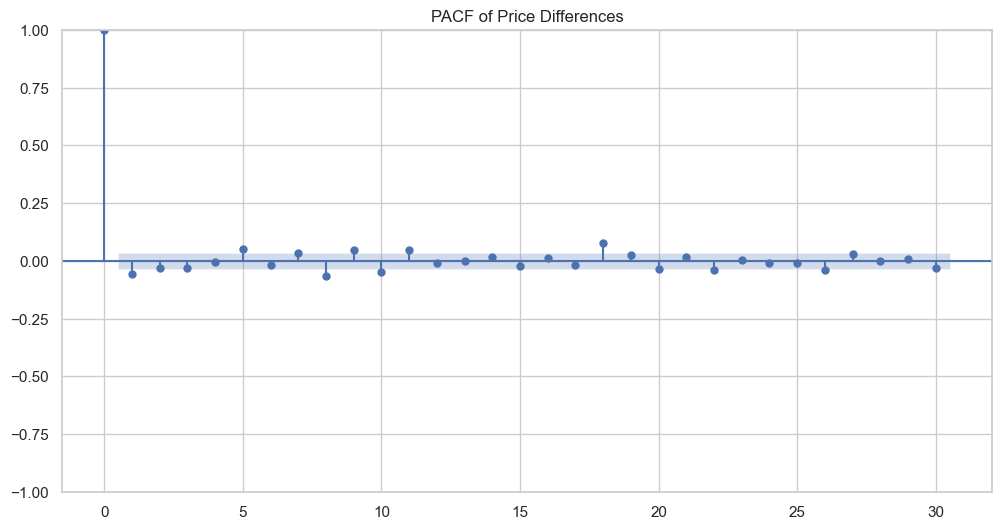

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

ticker = 'AAPL'
start_date = '2010-01-01'
end_date = '2023-01-01'
test_size = 0.2

df = yf.download(ticker, start=start_date, end=end_date)
prices = df[['Close']].dropna()
returns = np.log(df['Close'] / df['Close'].shift(1)).dropna()

fig, ax = plt.subplots(2, 1, figsize=(14, 10))
prices.plot(ax=ax[0], title=f'{ticker} Closing Prices')
returns.plot(ax=ax[1], title=f'{ticker} Daily Log Returns', color='orange')
plt.tight_layout()
plt.show()

def adf_test(series, name=''):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}: stat={result[0]:.4f}, p-value={result[1]:.4f}")
    print("Null Hypothesis (H0): The series is non-stationary")
    if result[1] < 0.05:
        print(f"--> {name} is stationary (reject H0)")
    else:
        print(f"--> {name} is non-stationary (fail to reject H0)")
    return result

def kpss_test(series, name=''):
    result = kpss(series.dropna(), regression='c', nlags="auto")
    print(f"KPSS Test for {name}: stat={result[0]:.4f}, p-value={result[1]:.4f}")
    print("Null Hypothesis (H0): The series is stationary")
    if result[1] < 0.05:
        print(f"--> {name} is non-stationary (reject H0)")
    else:
        print(f"--> {name} is stationary (fail to reject H0)")
    return result

print("------ Stationarity Tests for Prices: ------")
adf_test(prices, 'Prices')
kpss_test(prices, 'Prices')
plot_acf(prices, lags=30, title='ACF of Prices')
plt.show()
plot_pacf(prices, lags=30, title='PACF of Prices')
plt.show()

print("\n ------- Stationarity Tests for Returns:------")
adf_test(returns, 'Returns')
kpss_test(returns, 'Returns')
plot_acf(returns, lags=30, title='ACF of Returns')
plt.show()
plot_pacf(returns, lags=30, title='PACF of Returns')
plt.show()

price_diff = prices.diff().dropna()
adf_test(price_diff, 'Price Differences')
kpss_test(price_diff, 'Price Differences')
plot_acf(price_diff, lags=30, title='ACF of Price Differences')
plt.show()
plot_pacf(price_diff, lags=30, title='PACF of Price Differences')
plt.show()

 returns -> Train size: 2616, Test size: 655
 price -> Train size: 2617, Test size: 655

 searching best ARIMA model for Returns...


/Users/TGS/opt/anaconda3/envs/phase_1_basics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/TGS/opt/anaconda3/envs/phase_1_basics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/TGS/opt/anaconda3/envs/phase_1_basics/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/TGS/opt/anaconda3/envs/phase_1_basics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no ass

Best ARIMA(1, 0, 0) with AIC: -13763.01
                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 2616
Model:               SARIMAX(1, 0, 0)   Log Likelihood                6883.507
Date:                Fri, 10 Oct 2025   AIC                         -13763.015
Time:                        22:08:14   BIC                         -13751.276
Sample:                             0   HQIC                        -13758.763
                               - 2616                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0458      0.012     -3.782      0.000      -0.070      -0.022
sigma2         0.0003   4.42e-06     68.697      0.000       0.000       0.000
Ljung-Box (L

/Users/TGS/opt/anaconda3/envs/phase_1_basics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


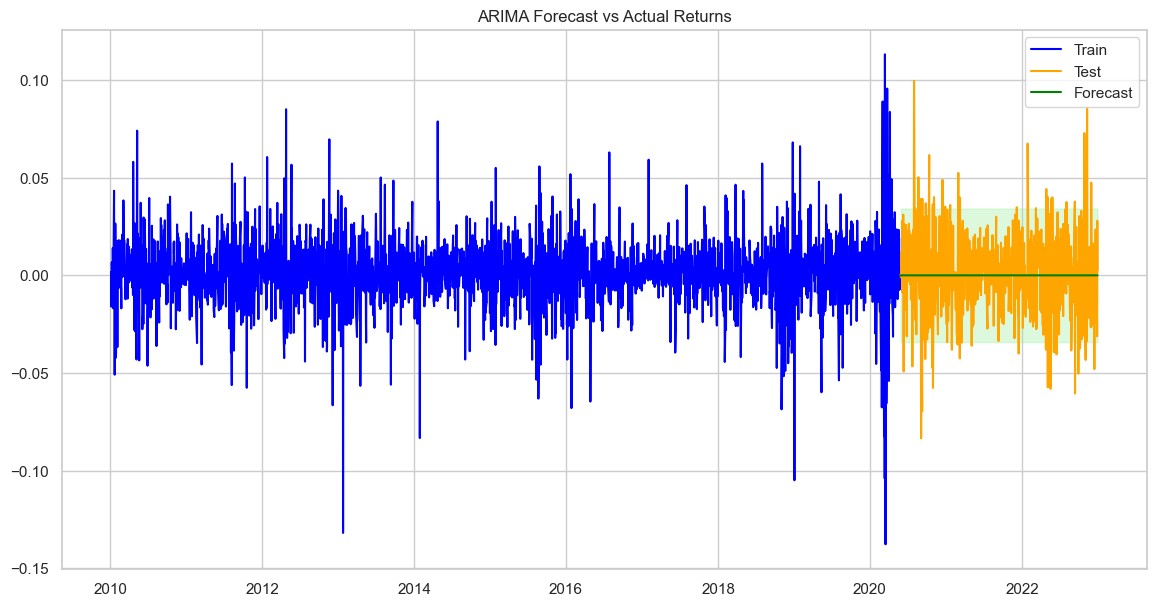

Returns Forecast MSE: 4.255534e-04


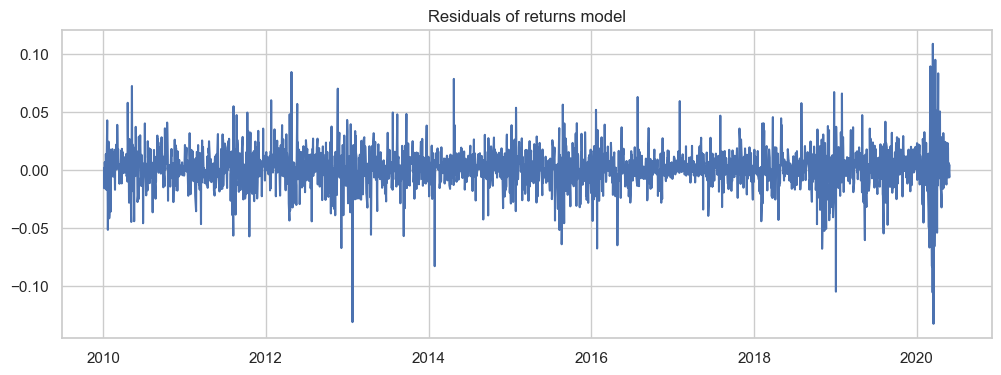

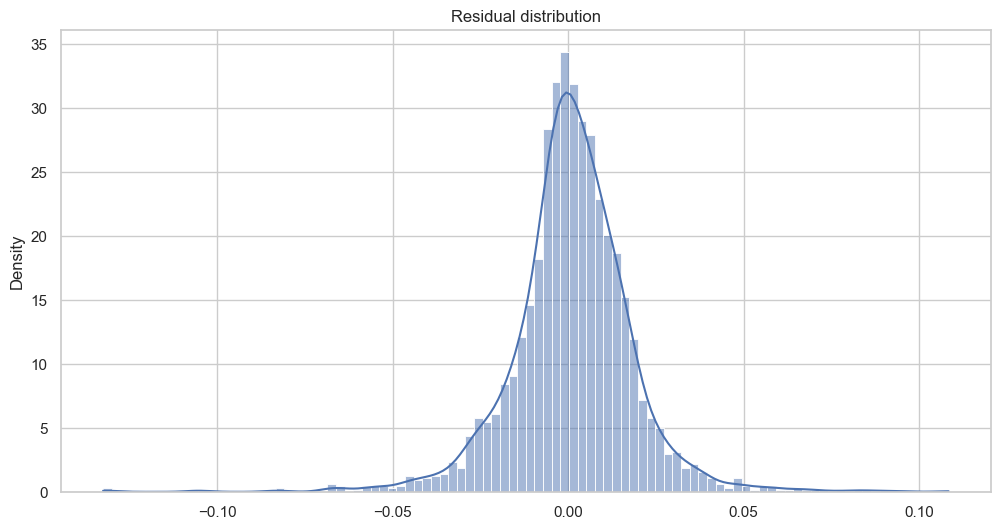

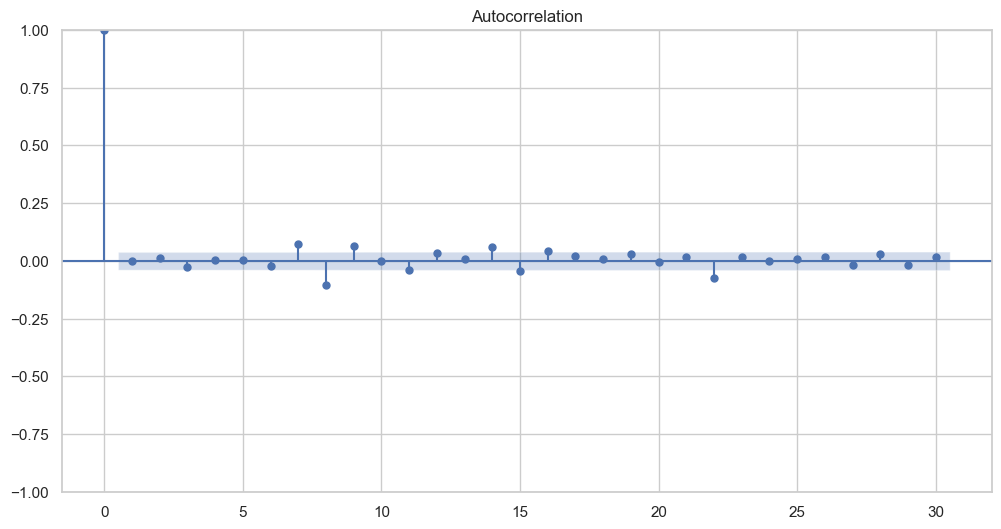

Ljung-Box:
       lb_stat     lb_pvalue
5    2.168366  8.253920e-01
10  54.920174  3.268362e-08
20  84.964294  5.552477e-10
Jarque-Bera p: 0.0


In [7]:
def train_test_split(series, test_size=0.2):
    split_idx = int(len(series) * (1 - test_size))
    train = series.iloc[:split_idx]
    test = series.iloc[split_idx:]
    return train, test

returns_train, returns_test = train_test_split(returns, test_size=test_size)
prices_train, prices_test = train_test_split(prices, test_size=test_size)

print(f" returns -> Train size: {len(returns_train)}, Test size: {len(returns_test)}")
print(f" price -> Train size: {len(prices_train)}, Test size: {len(prices_test)}")

def fit_arima_model(series_train, p_range=(0,3), d=0, q_range=(0,3), enforce_stationarity=True):
    best = None

    for p in range(p_range[0], p_range[1]+1):
        for q in range(q_range[0], q_range[1]+1):
            try:
                model = SARIMAX(series_train, order=(p, d, q), enforce_stationarity=enforce_stationarity)
                results = model.fit(disp=False)
                aic = results.aic
                if best is None or aic < best['aic']:
                    best = {'model': model, 'results':results, 'aic': aic, 'order': (p, d, q)}
            except Exception as e:
                continue
    return best 

print("\n searching best ARIMA model for Returns...")
best_returns_model = fit_arima_model(returns_train, p_range=(0,3), d=0, q_range=(0,3))
if best_returns_model:
    print(f"Best ARIMA{best_returns_model['order']} with AIC: {best_returns_model['aic']:.2f}")
    returns_model = best_returns_model['results']
    print(returns_model.summary())
else:
    print("No suitable ARIMA model found for Returns.")

# Use integer-based index for prediction to avoid KeyError
start_idx = len(returns_train)
end_idx = len(returns_train) + len(returns_test) - 1
pred = returns_model.get_prediction(start=start_idx, end=end_idx, dynamic=False)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()
# Align prediction index with test set
pred_mean.index = returns_test.index
pred_ci.index = returns_test.index

plt.figure(figsize=(14, 7))
plt.plot(returns_train.index, returns_train, label='Train', color='blue')
plt.plot(returns_test.index, returns_test, label='Test', color='orange')
plt.plot(pred_mean.index, pred_mean, label='Forecast', color='green')
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.title('ARIMA Forecast vs Actual Returns')
plt.legend()
plt.show()


mse_ret = mean_squared_error(returns_test, pred_mean)
print(f"Returns Forecast MSE: {mse_ret:.6e}")

# Residual diagnostics
resid = returns_model.resid
plt.figure(figsize=(12,4))
plt.plot(resid); plt.title("Residuals of returns model"); plt.show()


sns.histplot(resid, kde=True, stat="density"); plt.title("Residual distribution"); plt.show()

# 4. ACF of residuals
plot_acf(resid, lags=30); plt.show()

# 5. Ljung-Box
from statsmodels.stats.diagnostic import acorr_ljungbox
print("Ljung-Box:\n", acorr_ljungbox(resid, lags=[5,10,20], return_df=True))

# 6. Jarque-Bera
from scipy import stats
jb_stat, jb_p = stats.jarque_bera(resid)
print("Jarque-Bera p:", jb_p)

### Diagnostics: [link](https://medium.com/@ShankiiZ_/residual-analysis-in-time-series-612a450b08f5)
When it comes to analyzing time series data, one of the most important things to consider is the behavior of the residuals. Residuals are simply the difference between the actual data points and the values predicted by the model

Residual Diagnostics: White noise residuals are an indication that the model is a good fit for the data. It means that the model has captured all the relevant information in the time series, and there are no remaining patterns or trends that have not been accounted for. By assessing the residuals, we can diagnose any problems with the model and take appropriate steps to address them.

After fitting an ARIMA/SARIMAX model you should check that residuals behave like white noise. Here are the most useful diagnostics (with code and interpretation):

1) Residual time series (visual check): plot the times series. If no obvious trend, mean ≈ 0, no large structure. If you see patterns, model missed structure.

2) Residual histogram & KDE + mean/std : roughly symmetric around zero; but normality is not strictly required — only if you rely on parametric inference.

3) QQ-plot (normality visual): if points follow the line, residuals are roughly normal. Deviations in tails indicate non-normality (fat tails).

4) ACF of residuals (do residuals have remaining autocorrelation?): most autocorrelations should lie within the significance bands (no systematic spikes). Large spikes mean the model left serial correlation in residuals → underfitted.

5) Ljung–Box test (formal test for serial correlation) : Null hypothesis: residuals are uncorrelated (white noise) up to the given lag. Interpretation: p-value > 0.05 → fail to reject null → good (no autocorrelation). p-value < 0.05 → reject null → evidence of autocorrelation left in residuals (bad).

6) Jarque–Bera test (normality of residuals): Null: residuals are normally distributed. Interpretation: p < 0.05 → reject normality. (Note: financial residuals often aren’t perfectly normal; that alone is not decisive if forecasts are unbiased and uncorrelated.)

Short checklist: what “good” diagnostics look like

- Residual mean ≈ 0 and no obvious trend.

- ACF of residuals shows no significant spikes; Ljung-Box p-values > 0.05.

- Residuals approximately symmetric; Jarque-Bera p might be <0.05 often in finance — acceptable if other diagnostics are fine.

- ARCH test p-value > 0.05 means no volatility clustering — otherwise use GARCH.

- Reasonable MSE / MAE and prediction CI coverage near nominal level.


Searching best ARIMA for PRICES (difference d=1)...


/Users/TGS/opt/anaconda3/envs/phase_1_basics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/TGS/opt/anaconda3/envs/phase_1_basics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/TGS/opt/anaconda3/envs/phase_1_basics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/TGS/opt/anaconda3/envs/phase_1_basics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been

Best model for prices: {'model': <statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x130a20ca0>, 'results': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x1309b6560>, 'aic': np.float64(4813.207754122658), 'order': (2, 1, 3)}
Best prices ARIMA: order=(2,1,3) AIC=4813.2
                               SARIMAX Results                                
Dep. Variable:             Close_AAPL   No. Observations:                 2617
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -2400.604
Date:                Fri, 10 Oct 2025   AIC                           4813.208
Time:                        22:15:52   BIC                           4848.424
Sample:                             0   HQIC                          4825.964
                               - 2617                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      

/Users/TGS/opt/anaconda3/envs/phase_1_basics/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


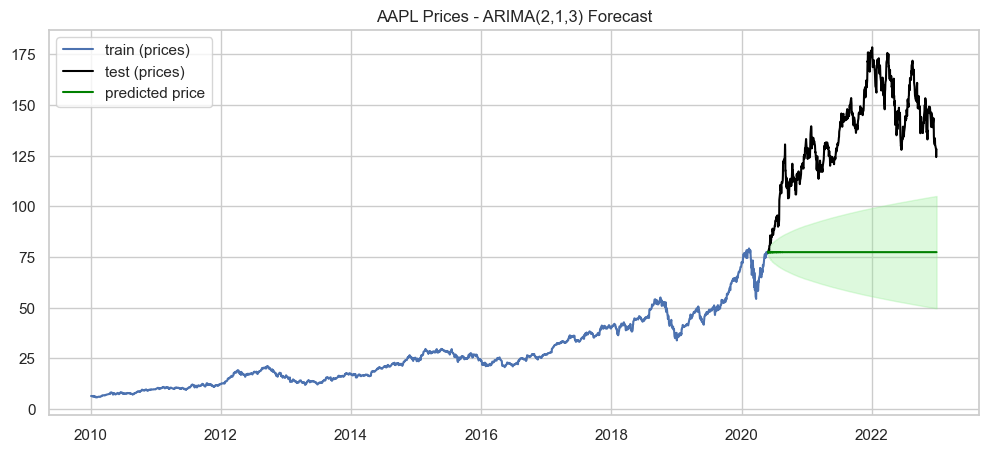

Prices Forecast MSE: 3949.069394


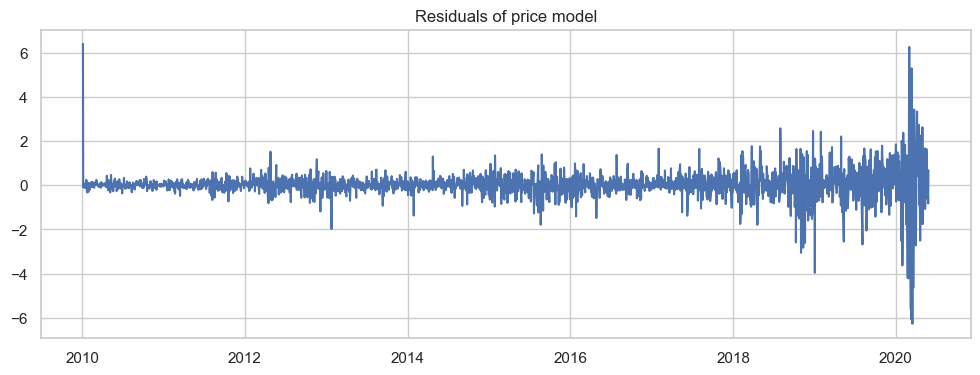

Ljung-Box p-values (lags 1..10):
1     9.580310e-01
5     1.857135e-02
10    7.553263e-10
Name: lb_pvalue, dtype: float64


In [13]:
print("\nSearching best ARIMA for PRICES (difference d=1)...")
best_price = fit_arima_model(prices_train, p_range=(0,3), d=1, q_range=(0,3))
print("Best model for prices:", best_price)
print(f"Best prices ARIMA: order=({best_price['order'][0]},{best_price['order'][1]},{best_price['order'][2]}) AIC={best_price['aic']:.1f}")
print(best_price['results'].summary())

# Forecast prices
start = len(prices_train)
end = len(prices_train) + len(prices_test) - 1
res_p = best_price['results']
pred_p = res_p.get_prediction(start=start, end=end, dynamic=False)
pred_p_mean = pred_p.predicted_mean
pred_p_ci = pred_p.conf_int()

# Align prediction index with test set
pred_p_mean.index = prices_test.index
pred_p_ci.index = prices_test.index

plt.figure(figsize=(12,5))
plt.plot(prices_train.index, prices_train, label='train (prices)')
plt.plot(prices_test.index, prices_test, label='test (prices)', color='black')
plt.plot(pred_p_mean.index, pred_p_mean, label='predicted price', color='green')
plt.fill_between(pred_p_ci.index, pred_p_ci.iloc[:,0], pred_p_ci.iloc[:,1], color='lightgreen', alpha=0.3)
plt.legend(); plt.title(f"{ticker} Prices - ARIMA({best_price['order'][0]},{best_price['order'][1]},{best_price['order'][2]}) Forecast")
plt.show()

mse_price = mean_squared_error(prices_test, pred_p_mean)
print(f"Prices Forecast MSE: {mse_price:.6f}")

# Residual diagnostics for price model
resid_p = res_p.resid
plt.figure(figsize=(12,4))
plt.plot(resid_p); plt.title("Residuals of price model"); plt.show()
print("Ljung-Box p-values (lags 1..10):")
print(acorr_ljungbox(resid_p, lags=[1,5,10], return_df=True)['lb_pvalue'])

## Explanations & How to interpret outputs

- ADF / KPSS: used to determine d. If price is non-stationary and returns are stationary → use d=1 for prices or model returns directly (d=0).

- ACF / PACF: visual guides to pick plausible p and q. PACF cutoff → AR(p). ACF cutoff → MA(q).

- Model selection grid: code runs a small (p,q) grid and picks the model with lowest AIC. That’s a simple automated approach (you can expand grid).

- Summary: res.summary() prints coefficients, standard errors, AIC, BIC — inspect significance of coefficients and AIC.

- Forecast plot: shows train/test and prediction + confidence intervals. Compare visually and compute MSE for numeric check.

- Residual diagnostics: plot residuals and run Ljung-Box test — if p-values are large (>0.05) the residuals look like white noise (good). If small, model misses structure._